# **삼성전자 주가 예측 프로젝트**
> 딥러닝을 통한 활용 아이디어 도출: 수업시간에 배운 내용 + 창의성

1.   수집 기간:
  - train: 2023.01.02 ~ 2024.06.28
  - test: 2024.07.01 ~ 2024.11.20
  - 단위: 일

2. 알고리즘:
  LSTM, RNN


---


참고문헌: http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020103

cf)
https://jypark1111.tistory.com/70 rnn 종류  
https://comp.fnguide.com/svo2/asp/SVD_Report_Summary.asp?pGB=1&gicode=A102780&cID=&MenuYn=Y&ReportGB=&NewMenuID=901&stkGb=770 fnguide 리포트: 사회적 변수 영향 (주가 등락 원인 분석)

# 1. 전처리
* pd.read_csv  
* [일자,] 시가, 고가, 저가, 거래량, 거래대금, 시가총액, [상장주식수,] 종가

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

stock = pd.read_csv('dl.csv', encoding="EUC-KR")  # np.loadtxt를 pd.read_csv로 변경 # encoding: 한글
stock.head()

,일자,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,종가
0,2023-01-02,55500,56100,55200,10031448,5.580000e+11,3.310000e+14,5969782550,55500
1,2023-01-03,55400,56000,54500,13547030,7.480000e+11,3.310000e+14,5969782550,55400
2,2023-01-04,55700,58000,55600,20188071,1.150000e+12,3.450000e+14,5969782550,57800
3,2023-01-05,58200,58800,57600,15682826,9.120000e+11,3.470000e+14,5969782550,58200
4,2023-01-06,58300,59400,57900,17334989,1.020000e+12,3.520000e+14,5969782550,59000


In [3]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      462 non-null    object 
 1   시가      462 non-null    int64  
 2   고가      462 non-null    int64  
 3   저가      462 non-null    int64  
 4   거래량     462 non-null    int64  
 5   거래대금    462 non-null    float64
 6   시가총액    462 non-null    float64
 7   상장주식수   462 non-null    int64  
 8   종가      462 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 32.6+ KB


In [4]:
stock.index = pd.to_datetime(stock['일자']) # datetime으로 변경 → 인덱스를 날짜로 바꾸기
stock = stock.drop('일자', axis=1)
stock.head()

,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,종가
일자,,,,,,,,
2023-01-02,55500,56100,55200,10031448,5.580000e+11,3.310000e+14,5969782550,55500
2023-01-03,55400,56000,54500,13547030,7.480000e+11,3.310000e+14,5969782550,55400
2023-01-04,55700,58000,55600,20188071,1.150000e+12,3.450000e+14,5969782550,57800
2023-01-05,58200,58800,57600,15682826,9.120000e+11,3.470000e+14,5969782550,58200
2023-01-06,58300,59400,57900,17334989,1.020000e+12,3.520000e+14,5969782550,59000


In [5]:
stock.describe()

,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,종가
count,462.000000,462.000000,462.000000,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,462.000000
mean,70502.597403,71095.887446,69809.090909,1.749686e+07,1.233468e+12,4.202641e+14,5.969783e+09,70399.567100
std,7447.726273,7458.376500,7355.580144,8.404638e+06,6.043214e+11,4.440715e+13,0.000000e+00,7435.515978
min,50200.000000,51800.000000,49900.000000,5.824628e+06,3.890000e+11,2.980000e+14,5.969783e+09,49900.000000
25%,65000.000000,65425.000000,64225.000000,1.174975e+07,8.155000e+11,3.862500e+14,5.969783e+09,64750.000000
50%,71200.000000,71650.000000,70500.000000,1.492119e+07,1.050000e+12,4.240000e+14,5.969783e+09,71050.000000
75%,75000.000000,75875.000000,74200.000000,2.034296e+07,1.517500e+12,4.480000e+14,5.969783e+09,75075.000000
max,88500.000000,88800.000000,87100.000000,5.769127e+07,4.210000e+12,5.240000e+14,5.969783e+09,87800.000000


In [6]:
stock7 = stock.drop('상장주식수', axis=1) # min=max인 상장주식수 제외 (∵정규화 시 문제가 됨)
stock7.head()

,시가,고가,저가,거래량,거래대금,시가총액,종가
일자,,,,,,,
2023-01-02,55500,56100,55200,10031448,5.580000e+11,3.310000e+14,55500
2023-01-03,55400,56000,54500,13547030,7.480000e+11,3.310000e+14,55400
2023-01-04,55700,58000,55600,20188071,1.150000e+12,3.450000e+14,57800
2023-01-05,58200,58800,57600,15682826,9.120000e+11,3.470000e+14,58200
2023-01-06,58300,59400,57900,17334989,1.020000e+12,3.520000e+14,59000


In [7]:
stock4 = stock7.drop(['거래량','거래대금','시가총액'], axis=1)
stock4.head()

,시가,고가,저가,종가
일자,,,,
2023-01-02,55500,56100,55200,55500
2023-01-03,55400,56000,54500,55400
2023-01-04,55700,58000,55600,57800
2023-01-05,58200,58800,57600,58200
2023-01-06,58300,59400,57900,59000


# 부록. 종가 시각화

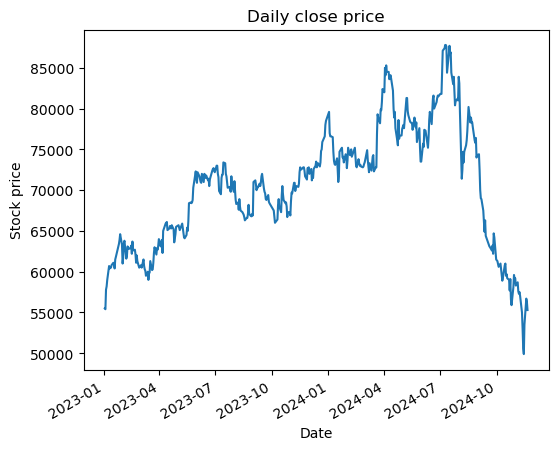

In [8]:
# 일별 종가 시각화
plt.rcParams['figure.figsize'] = [6, 5]
stock['종가'].plot()
plt.title('Daily close price')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.savefig('종가.jpg')
plt.show()

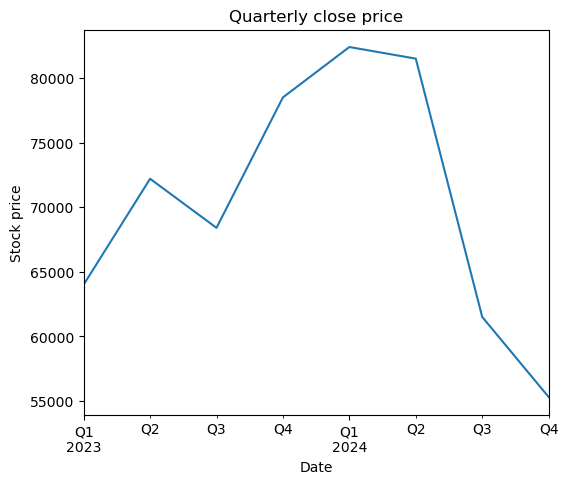

In [9]:
# 분기별 종가 시각화
plt.rcParams['figure.figsize'] = [6, 5]
stock_quarterly = stock['종가'].resample('Q').ffill()
stock_quarterly.plot()
plt.title('Quarterly close price')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.savefig('분기별 종가.jpg')
plt.show()

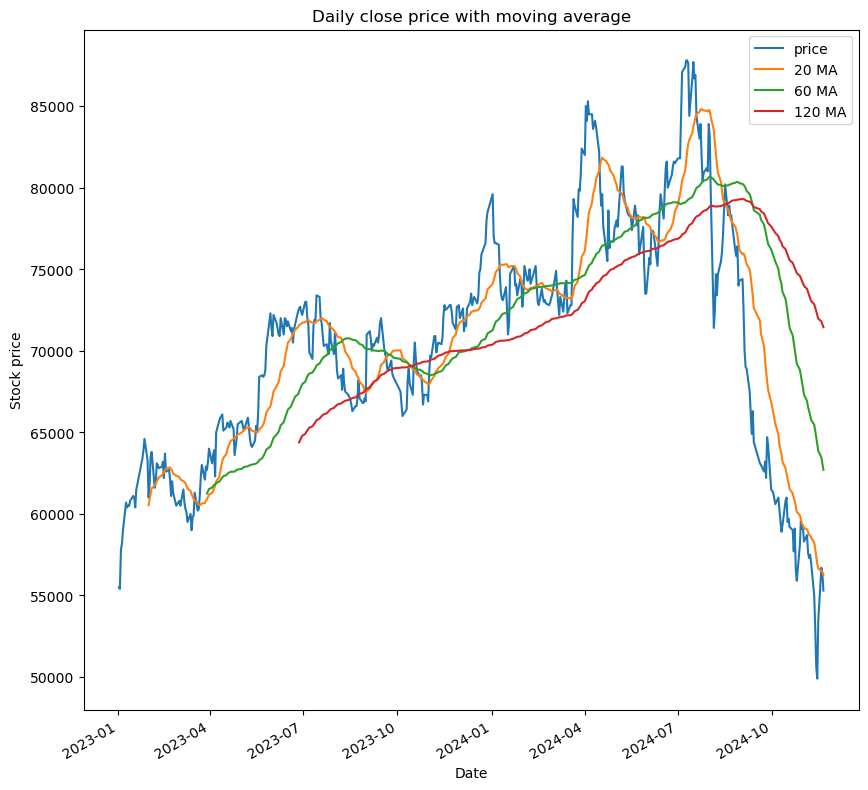

In [10]:
# 이동 평균선: 과거 n일 동안의 주가 평균값 (20일: 단기, 60일: 중기, 120일: 장기)
plt.rcParams['figure.figsize'] = [10, 10]
stock['종가'].plot(label='price')
stock['종가'].rolling(20).mean().plot(label='20 MA')
stock['종가'].rolling(60).mean().plot(label='60 MA')
stock['종가'].rolling(120).mean().plot(label='120 MA')
plt.legend(loc='best')
plt.title('Daily close price with moving average')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.savefig('이동 평균선.jpg')
plt.show()

# 2. 4개 변수 분석

## 2-1. LSTM
* to_numpy()
* [일자,] 시가, 고가, 저가, 거래량, 거래대금, 시가총액, [상장주식수,] 종가

In [11]:
np.random.seed(1111)
tf.random.set_seed(1111)

In [12]:
def Scale(data):
  min = np.min(data, 0)
  max = np.max(data, 0)
  return (data-min)/(max-min), min, max

In [13]:
seq_len = 10  # 10개씩 넣기
data_dim = 4  # 컬럼수
hidden_dim = 10
output_dim = 1
l_rate = 0.01
epochs = 300

In [14]:
stock4_array = stock4.to_numpy() # numpy 배열로 변환 (np.loadtxt처럼)
print("행:", stock4_array.shape[0], ", 열:", stock4_array.shape[1]) # 컬럼명과 일자(=인덱스)는 포함되지 않았다는 것을 확인

행: 462 , 열: 4


In [15]:
stock4_array, S4_min, S4_max = Scale(stock4_array) # 정규화

x4 = stock4_array
y4 = stock4_array[:,[-1]] # 목표변수

In [16]:
x4_data = []
y4_data = []
total_len = len(y4)-seq_len

for i in range(total_len):
  x4_1 = x4[i:i+seq_len]
  y4_1 = y4[i+seq_len]

  x4_data.append(x4_1)
  y4_data.append(y4_1)

x4_data = np.array(x4_data)
y4_data = np.array(y4_data)

# train / test 분리
split_index = stock.index.get_loc('2024-06-28') # 날짜 기준으로 행 번호 찾기 (∵stock7_array에는 날짜 없음)
x4_train, x4_test = x4_data[:split_index], x4_data[split_index:] # 2019~2024.2분기
y4_train, y4_test = y4_data[:split_index], y4_data[split_index:] # 2024.3분기~

In [17]:
# 모델
model_lstm_v4 = tf.keras.Sequential([
    tf.keras.layers.LSTM(hidden_dim, return_sequences=True, input_shape=(seq_len, data_dim)) ,
    tf.keras.layers.LSTM(hidden_dim) ,
    tf.keras.layers.Dense(output_dim)
])

model_lstm_v4.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='mse')

# 학습
history_lstm_v4 = model_lstm_v4.fit(x4_train, y4_train,
                    epochs=epochs,
                    batch_size=32,
                    verbose=2)

# 예측
test_predict_lstm_v4 = model_lstm_v4.predict(x4_test)

test_predict_rescaled_lstm_v4 = test_predict_lstm_v4*(S4_max[-1]-S4_min[-1])+S4_min[-1]
y4_test_rescaled_lstm = y4_test*(S4_max[-1]-S4_min[-1])+S4_min[-1]

test_error_lstm_v4 = np.sqrt(np.mean(np.square(y4_test_rescaled_lstm - test_predict_rescaled_lstm_v4)))
print("test_error: {}".format(test_error_lstm_v4))

Epoch 1/300


C:\Users\hkssn\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 - 5s - 390ms/step - loss: 0.0821
Epoch 2/300
12/12 - 0s - 8ms/step - loss: 0.0225
Epoch 3/300
12/12 - 0s - 9ms/step - loss: 0.0113
Epoch 4/300
12/12 - 0s - 8ms/step - loss: 0.0059
Epoch 5/300
12/12 - 0s - 8ms/step - loss: 0.0031
Epoch 6/300
12/12 - 0s - 7ms/step - loss: 0.0026
Epoch 7/300
12/12 - 0s - 11ms/step - loss: 0.0023
Epoch 8/300
12/12 - 0s - 10ms/step - loss: 0.0023
Epoch 9/300
12/12 - 0s - 10ms/step - loss: 0.0022
Epoch 10/300
12/12 - 0s - 8ms/step - loss: 0.0021
Epoch 11/300
12/12 - 0s - 12ms/step - loss: 0.0021
Epoch 12/300
12/12 - 0s - 13ms/step - loss: 0.0020
Epoch 13/300
12/12 - 0s - 11ms/step - loss: 0.0020
Epoch 14/300
12/12 - 0s - 11ms/step - loss: 0.0019
Epoch 15/300
12/12 - 0s - 9ms/step - loss: 0.0019
Epoch 16/300
12/12 - 0s - 10ms/step - loss: 0.0019
Epoch 17/300
12/12 - 0s - 8ms/step - loss: 0.0019
Epoch 18/300
12/12 - 0s - 8ms/step - loss: 0.0018
Epoch 19/300
12/12 - 0s - 8ms/step - loss: 0.0018
Epoch 20/300
12/12 - 0s - 8ms/step - loss: 0.0018
Epoch 21/30

In [18]:
stock_pred_lstm_v4 = test_predict_rescaled_lstm_v4[-1]
print("주가예측:", stock_pred_lstm_v4)

주가예측: [55726.656]


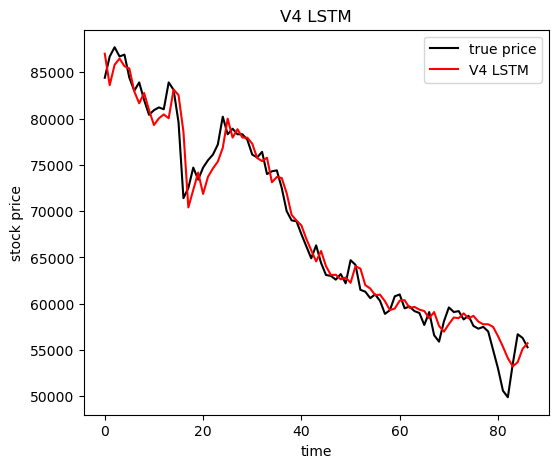

In [50]:
# 시각화
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(y4_test_rescaled_lstm, color='black', label="true price")
plt.plot(test_predict_rescaled_lstm_v4, color='red', linewidth=1.5, label="V4 LSTM")
plt.title('V4 LSTM')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('V4LSTM.jpg')

plt.show()

## 2-2. RNN - SimpleRNNCell
: 기본 RNN 모델

In [20]:
from tensorflow.keras.layers import RNN, SimpleRNNCell

model_rnn_v4 = tf.keras.Sequential([
    RNN(SimpleRNNCell(hidden_dim), return_sequences=True, input_shape=(seq_len, data_dim)),
    RNN(SimpleRNNCell(hidden_dim)),
    tf.keras.layers.Dense(output_dim)
])

model_rnn_v4.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='mse')



# 학습
history_rnn_v4 = model_rnn_v4.fit(x4_train, y4_train,
                    epochs=epochs,
                    batch_size=32,
                    verbose=2)

# 예측
test_predict_rnn_v4 = model_rnn_v4.predict(x4_test)

test_predict_rescaled_rnn_v4 = test_predict_rnn_v4*(S4_max[-1]-S4_min[-1])+S4_min[-1]
y4_test_rescaled_rnn = y4_test*(S4_max[-1]-S4_min[-1])+S4_min[-1]

test_error_rnn_v4 = np.sqrt(np.mean(np.square(y4_test_rescaled_rnn - test_predict_rescaled_rnn_v4)))
print("test_error: {}".format(test_error_rnn_v4))

Epoch 1/300


C:\Users\hkssn\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 - 5s - 393ms/step - loss: 0.0874
Epoch 2/300
12/12 - 0s - 8ms/step - loss: 0.0076
Epoch 3/300
12/12 - 0s - 8ms/step - loss: 0.0043
Epoch 4/300
12/12 - 0s - 8ms/step - loss: 0.0029
Epoch 5/300
12/12 - 0s - 8ms/step - loss: 0.0023
Epoch 6/300
12/12 - 0s - 9ms/step - loss: 0.0021
Epoch 7/300
12/12 - 0s - 9ms/step - loss: 0.0019
Epoch 8/300
12/12 - 0s - 9ms/step - loss: 0.0018
Epoch 9/300
12/12 - 0s - 10ms/step - loss: 0.0017
Epoch 10/300
12/12 - 0s - 10ms/step - loss: 0.0017
Epoch 11/300
12/12 - 0s - 10ms/step - loss: 0.0016
Epoch 12/300
12/12 - 0s - 8ms/step - loss: 0.0016
Epoch 13/300
12/12 - 0s - 9ms/step - loss: 0.0015
Epoch 14/300
12/12 - 0s - 10ms/step - loss: 0.0015
Epoch 15/300
12/12 - 0s - 10ms/step - loss: 0.0014
Epoch 16/300
12/12 - 0s - 10ms/step - loss: 0.0014
Epoch 17/300
12/12 - 0s - 9ms/step - loss: 0.0014
Epoch 18/300
12/12 - 0s - 10ms/step - loss: 0.0013
Epoch 19/300
12/12 - 0s - 9ms/step - loss: 0.0013
Epoch 20/300
12/12 - 0s - 9ms/step - loss: 0.0013
Epoch 21/300

In [21]:
stock_pred_rnn_v4 = test_predict_rescaled_rnn_v4[-1]
print("주가예측:", stock_pred_rnn_v4)

주가예측: [56540.15]


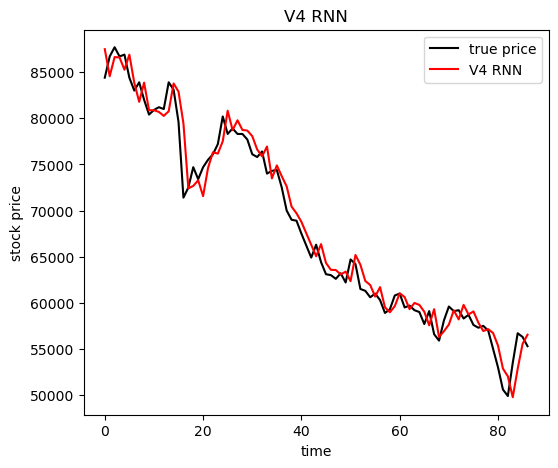

In [51]:
# 시각화
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(y4_test_rescaled_rnn, color='black', label="true price")
plt.plot(test_predict_rescaled_rnn_v4, color='red', linewidth=1.5, label="V4 RNN")
plt.title('V4 RNN')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('V4RNN.jpg')

plt.show()

## 2-3. RNN - GRUCell
: LSTM을 간단화한 모델

- update gate: 중요한 정보 업데이트
- reset gate: 보존

In [23]:
from tensorflow.keras.layers import RNN, GRUCell

model_rnn_gru_v4 = tf.keras.Sequential([
    RNN(GRUCell(hidden_dim), return_sequences=True, input_shape=(seq_len, data_dim)),
    RNN(GRUCell(hidden_dim)),
    tf.keras.layers.Dense(output_dim)
])

model_rnn_gru_v4.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='mse')



# 학습
history_rnn_gru_v4 = model_rnn_gru_v4.fit(x4_train, y4_train,
                    epochs=epochs,
                    batch_size=32,
                    verbose=2)

# 예측
test_predict_rnn_gru_v4 = model_rnn_gru_v4.predict(x4_test)

test_predict_rescaled_rnn_gru_v4 = test_predict_rnn_gru_v4*(S4_max[-1]-S4_min[-1])+S4_min[-1]
y4_test_rescaled_rnn_gru = y4_test*(S4_max[-1]-S4_min[-1])+S4_min[-1]

test_error_rnn_gru_v4 = np.sqrt(np.mean(np.square(y4_test_rescaled_rnn_gru - test_predict_rescaled_rnn_gru_v4)))
print("test_error: {}".format(test_error_rnn_gru_v4))

Epoch 1/300


C:\Users\hkssn\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 - 5s - 440ms/step - loss: 0.1583
Epoch 2/300
12/12 - 0s - 10ms/step - loss: 0.0180
Epoch 3/300
12/12 - 0s - 12ms/step - loss: 0.0083
Epoch 4/300
12/12 - 0s - 13ms/step - loss: 0.0045
Epoch 5/300
12/12 - 0s - 11ms/step - loss: 0.0028
Epoch 6/300
12/12 - 0s - 13ms/step - loss: 0.0018
Epoch 7/300
12/12 - 0s - 13ms/step - loss: 0.0016
Epoch 8/300
12/12 - 0s - 17ms/step - loss: 0.0015
Epoch 9/300
12/12 - 0s - 15ms/step - loss: 0.0014
Epoch 10/300
12/12 - 0s - 16ms/step - loss: 0.0014
Epoch 11/300
12/12 - 0s - 17ms/step - loss: 0.0013
Epoch 12/300
12/12 - 0s - 15ms/step - loss: 0.0013
Epoch 13/300
12/12 - 0s - 17ms/step - loss: 0.0012
Epoch 14/300
12/12 - 0s - 16ms/step - loss: 0.0012
Epoch 15/300
12/12 - 0s - 16ms/step - loss: 0.0011
Epoch 16/300
12/12 - 0s - 16ms/step - loss: 0.0011
Epoch 17/300
12/12 - 0s - 15ms/step - loss: 0.0011
Epoch 18/300
12/12 - 0s - 15ms/step - loss: 0.0011
Epoch 19/300
12/12 - 0s - 16ms/step - loss: 0.0010
Epoch 20/300
12/12 - 0s - 15ms/step - loss: 0.0010


In [24]:
stock_pred_rnn_gru_v4 = test_predict_rescaled_rnn_gru_v4[-1]
print("주가예측:", stock_pred_rnn_gru_v4)

주가예측: [55949.42]


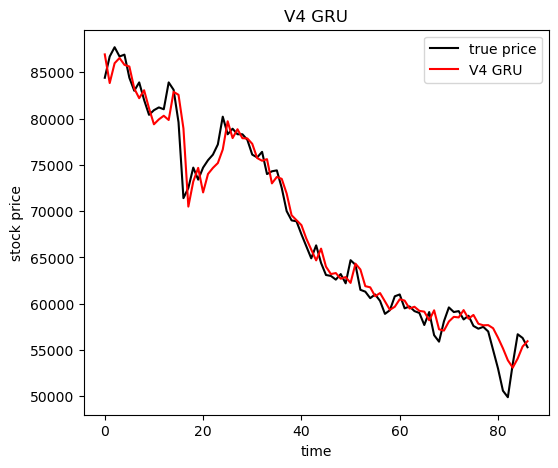

In [52]:
# 시각화
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(y4_test_rescaled_rnn_gru, color='black', label="true price")
plt.plot(test_predict_rescaled_rnn_gru_v4, color='red', linewidth=1.5, label="V4 GRU")
plt.title('V4 GRU')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('V4GRU.jpg')

plt.show()

# 3. 8개 변수 분석

## 3-1. LSTM
* to_numpy()
* [일자,] 시가, 고가, 저가, 거래량, 거래대금, 시가총액, [상장주식수,] 종가

In [26]:
np.random.seed(1111)
tf.random.set_seed(1111)

In [27]:
def Scale(data):
  min = np.min(data, 0)
  max = np.max(data, 0)
  return (data-min)/(max-min), min, max

In [28]:
seq_len = 10  # 10개씩 넣기
data_dim = 7  # 컬럼수
hidden_dim = 10
output_dim = 1
l_rate = 0.01
epochs = 300

In [29]:
stock7_array = stock7.to_numpy() # numpy 배열로 변환 (np.loadtxt처럼)
print("행:", stock7_array.shape[0], ", 열:", stock7_array.shape[1]) # 컬럼명과 일자(=인덱스)는 포함되지 않았다는 것을 확인

행: 462 , 열: 7


In [30]:
stock7_array, S7_min, S7_max = Scale(stock7_array) # 정규화

x7 = stock7_array
y7 = stock7_array[:,[-1]] # 목표변수

In [31]:
x7_data = []
y7_data = []
total_len = len(y7)-seq_len

for i in range(total_len):
  x7_1 = x7[i:i+seq_len]
  y7_1 = y7[i+seq_len]

  x7_data.append(x7_1)
  y7_data.append(y7_1)

x7_data = np.array(x7_data)
y7_data = np.array(y7_data)

# train / test 분리
split_index = stock.index.get_loc('2024-06-28') # 날짜 기준으로 행 번호 찾기 (∵stock7_array에는 날짜 없음)
x7_train, x7_test = x7_data[:split_index], x7_data[split_index:] # 2019~2024.2분기
y7_train, y7_test = y7_data[:split_index], y7_data[split_index:] # 2024.3분기~

In [32]:
# 모델
model_lstm_v7 = tf.keras.Sequential([
    tf.keras.layers.LSTM(hidden_dim, return_sequences=True, input_shape=(seq_len, data_dim)) ,
    tf.keras.layers.LSTM(hidden_dim) ,
    tf.keras.layers.Dense(output_dim)
])

model_lstm_v7.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='mse')

# 학습
history_lstm_v7 = model_lstm_v7.fit(x7_train, y7_train,
                    epochs=epochs,
                    batch_size=32,
                    verbose=2)

# 예측
test_predict_lstm_v7 = model_lstm_v7.predict(x7_test)

test_predict_rescaled_lstm_v7 = test_predict_lstm_v7*(S7_max[-1]-S7_min[-1])+S7_min[-1]
y7_test_rescaled_lstm = y7_test*(S7_max[-1]-S7_min[-1])+S7_min[-1]

test_error_lstm_v7 = np.sqrt(np.mean(np.square(y7_test_rescaled_lstm - test_predict_rescaled_lstm_v7)))
print("test_error: {}".format(test_error_lstm_v7))

Epoch 1/300


C:\Users\hkssn\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 - 6s - 489ms/step - loss: 0.0637
Epoch 2/300
12/12 - 0s - 9ms/step - loss: 0.0187
Epoch 3/300
12/12 - 0s - 12ms/step - loss: 0.0078
Epoch 4/300
12/12 - 0s - 14ms/step - loss: 0.0045
Epoch 5/300
12/12 - 0s - 14ms/step - loss: 0.0033
Epoch 6/300
12/12 - 0s - 15ms/step - loss: 0.0029
Epoch 7/300
12/12 - 0s - 13ms/step - loss: 0.0026
Epoch 8/300
12/12 - 0s - 14ms/step - loss: 0.0025
Epoch 9/300
12/12 - 0s - 13ms/step - loss: 0.0024
Epoch 10/300
12/12 - 0s - 6ms/step - loss: 0.0024
Epoch 11/300
12/12 - 0s - 7ms/step - loss: 0.0023
Epoch 12/300
12/12 - 0s - 7ms/step - loss: 0.0022
Epoch 13/300
12/12 - 0s - 7ms/step - loss: 0.0021
Epoch 14/300
12/12 - 0s - 9ms/step - loss: 0.0021
Epoch 15/300
12/12 - 0s - 11ms/step - loss: 0.0020
Epoch 16/300
12/12 - 0s - 7ms/step - loss: 0.0019
Epoch 17/300
12/12 - 0s - 8ms/step - loss: 0.0019
Epoch 18/300
12/12 - 0s - 9ms/step - loss: 0.0018
Epoch 19/300
12/12 - 0s - 10ms/step - loss: 0.0018
Epoch 20/300
12/12 - 0s - 11ms/step - loss: 0.0018
Epoch 21/

In [33]:
stock_pred_lstm_v7 = test_predict_rescaled_lstm_v7[-1]
print("주가예측:", stock_pred_lstm_v7)

주가예측: [55789.113]


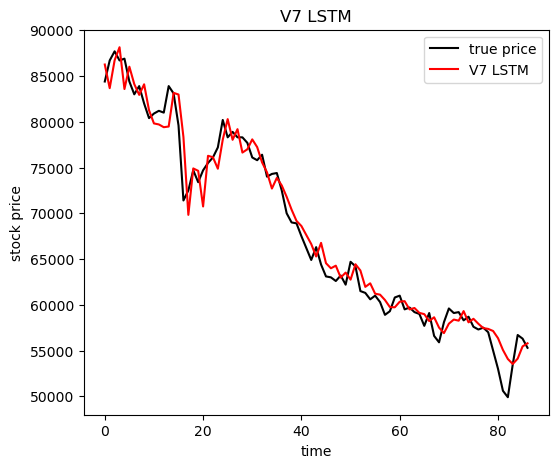

In [53]:
# 시각화
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(y7_test_rescaled_lstm, color='black', label="true price")
plt.plot(test_predict_rescaled_lstm_v7, color='red', linewidth=1.5, label="V7 LSTM")
plt.title('V7 LSTM')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('V7LSTM.jpg')

plt.show()

## 3-2. RNN - SimpleRNNCell
: 기본 RNN 모델

In [35]:
from tensorflow.keras.layers import RNN, SimpleRNNCell

model_rnn_v7 = tf.keras.Sequential([
    RNN(SimpleRNNCell(hidden_dim), return_sequences=True, input_shape=(seq_len, data_dim)),
    RNN(SimpleRNNCell(hidden_dim)),
    tf.keras.layers.Dense(output_dim)
])

model_rnn_v7.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='mse')



# 학습
history_rnn_v7 = model_rnn_v7.fit(x7_train, y7_train,
                    epochs=epochs,
                    batch_size=32,
                    verbose=2)

# 예측
test_predict_rnn_v7 = model_rnn_v7.predict(x7_test)

test_predict_rescaled_rnn_v7 = test_predict_rnn_v7*(S7_max[-1]-S7_min[-1])+S7_min[-1]
y7_test_rescaled_rnn = y7_test*(S7_max[-1]-S7_min[-1])+S7_min[-1]

test_error_rnn_v7 = np.sqrt(np.mean(np.square(y7_test_rescaled_rnn - test_predict_rescaled_rnn_v7)))
print("test_error: {}".format(test_error_rnn_v7))

Epoch 1/300


C:\Users\hkssn\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 - 5s - 436ms/step - loss: 0.2896
Epoch 2/300
12/12 - 0s - 8ms/step - loss: 0.0169
Epoch 3/300
12/12 - 0s - 8ms/step - loss: 0.0056
Epoch 4/300
12/12 - 0s - 9ms/step - loss: 0.0035
Epoch 5/300
12/12 - 0s - 8ms/step - loss: 0.0027
Epoch 6/300
12/12 - 0s - 13ms/step - loss: 0.0022
Epoch 7/300
12/12 - 0s - 9ms/step - loss: 0.0020
Epoch 8/300
12/12 - 0s - 10ms/step - loss: 0.0019
Epoch 9/300
12/12 - 0s - 8ms/step - loss: 0.0018
Epoch 10/300
12/12 - 0s - 7ms/step - loss: 0.0018
Epoch 11/300
12/12 - 0s - 9ms/step - loss: 0.0017
Epoch 12/300
12/12 - 0s - 7ms/step - loss: 0.0017
Epoch 13/300
12/12 - 0s - 10ms/step - loss: 0.0017
Epoch 14/300
12/12 - 0s - 11ms/step - loss: 0.0017
Epoch 15/300
12/12 - 0s - 10ms/step - loss: 0.0017
Epoch 16/300
12/12 - 0s - 10ms/step - loss: 0.0017
Epoch 17/300
12/12 - 0s - 10ms/step - loss: 0.0017
Epoch 18/300
12/12 - 0s - 10ms/step - loss: 0.0017
Epoch 19/300
12/12 - 0s - 10ms/step - loss: 0.0016
Epoch 20/300
12/12 - 0s - 11ms/step - loss: 0.0016
Epoch 21/

In [36]:
stock_pred_rnn_v7 = test_predict_rescaled_rnn_v7[-1]
print("주가예측:", stock_pred_rnn_v7)

주가예측: [40315.74]


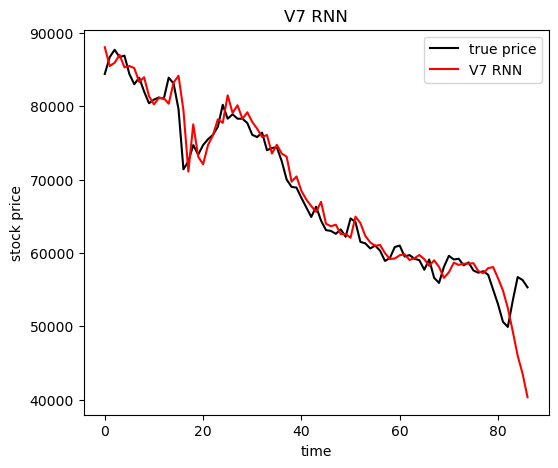

In [54]:
# 시각화
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(y7_test_rescaled_rnn, color='black', label="true price")
plt.plot(test_predict_rescaled_rnn_v7, color='red', linewidth=1.5, label="V7 RNN")
plt.title('V7 RNN')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('V7RNN.jpg')

plt.show()

## 3-3. RNN - GRUCell
: LSTM을 간단화한 모델

- update gate: 중요한 정보 업데이트
- reset gate: 보존

In [38]:
from tensorflow.keras.layers import RNN, GRUCell

model_rnn_gru_v7 = tf.keras.Sequential([
    RNN(GRUCell(hidden_dim), return_sequences=True, input_shape=(seq_len, data_dim)),
    RNN(GRUCell(hidden_dim)),
    tf.keras.layers.Dense(output_dim)
])

model_rnn_gru_v7.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='mse')



# 학습
history_rnn_gru_v7 = model_rnn_gru_v7.fit(x7_train, y7_train,
                    epochs=epochs,
                    batch_size=32,
                    verbose=2)

# 예측
test_predict_rnn_gru_v7 = model_rnn_gru_v7.predict(x7_test)

test_predict_rescaled_rnn_gru_v7 = test_predict_rnn_gru_v7*(S7_max[-1]-S7_min[-1])+S7_min[-1]
y7_test_rescaled_rnn_gru = y7_test*(S7_max[-1]-S7_min[-1])+S7_min[-1]

test_error_rnn_gru_v7 = np.sqrt(np.mean(np.square(y7_test_rescaled_rnn_gru - test_predict_rescaled_rnn_gru_v7)))
print("test_error: {}".format(test_error_rnn_gru_v7))

Epoch 1/300


C:\Users\hkssn\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 - 7s - 567ms/step - loss: 0.0928
Epoch 2/300
12/12 - 0s - 9ms/step - loss: 0.0203
Epoch 3/300
12/12 - 0s - 11ms/step - loss: 0.0061
Epoch 4/300
12/12 - 0s - 14ms/step - loss: 0.0038
Epoch 5/300
12/12 - 0s - 11ms/step - loss: 0.0028
Epoch 6/300
12/12 - 0s - 14ms/step - loss: 0.0017
Epoch 7/300
12/12 - 0s - 10ms/step - loss: 0.0013
Epoch 8/300
12/12 - 0s - 14ms/step - loss: 0.0013
Epoch 9/300
12/12 - 0s - 14ms/step - loss: 0.0013
Epoch 10/300
12/12 - 0s - 13ms/step - loss: 0.0013
Epoch 11/300
12/12 - 0s - 14ms/step - loss: 0.0012
Epoch 12/300
12/12 - 0s - 15ms/step - loss: 0.0012
Epoch 13/300
12/12 - 0s - 17ms/step - loss: 0.0012
Epoch 14/300
12/12 - 0s - 14ms/step - loss: 0.0012
Epoch 15/300
12/12 - 0s - 16ms/step - loss: 0.0012
Epoch 16/300
12/12 - 0s - 14ms/step - loss: 0.0011
Epoch 17/300
12/12 - 0s - 13ms/step - loss: 0.0011
Epoch 18/300
12/12 - 0s - 13ms/step - loss: 0.0011
Epoch 19/300
12/12 - 0s - 15ms/step - loss: 0.0011
Epoch 20/300
12/12 - 0s - 15ms/step - loss: 0.0010
E

In [39]:
stock_pred_rnn_gru_v7 = test_predict_rescaled_rnn_gru_v7[-1]
print("주가예측:", stock_pred_rnn_gru_v7)

주가예측: [53739.766]


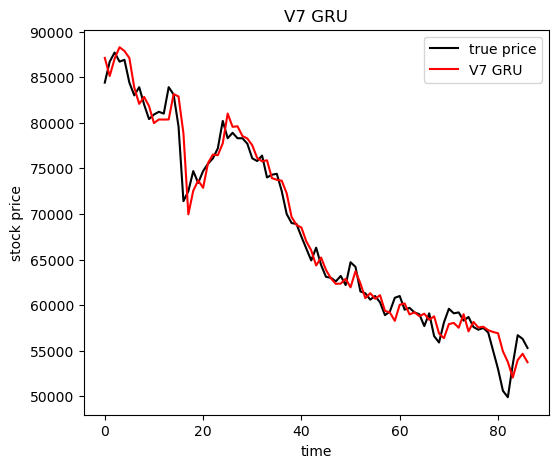

In [55]:
# 시각화
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(y7_test_rescaled_rnn_gru, color='black', label="true price")
plt.plot(test_predict_rescaled_rnn_gru_v7, color='red', linewidth=1.5, label="V7 GRU")
plt.title('V7 GRU')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('V7GRU.jpg')

plt.show()

# 4. 결론
1) 변수가 4개일 때 RNN - GRUCell으로 예측한 종가가 실제와 가장 유사했다.  
2) 변수가 4개일 때 LSTM이 test_error가 가장 작다.
3) 변수가 늘어남에 따라 가장 타격을 크게 받는 것은 RNN - SimpleRNN이고, 가장 타격을 적게 받는 것은 LSTM이다.

**V4 LSTM**  
2024.11.21  
실제 종가: 56400  
예측 종가: 55726.656 (-673.344)  
test_error: 1797.16020347792  

**V4 RNN**  
2024.11.21  
실제 종가: 56400    
예측 종가: 56540.15 (+140.15)  
test_error: 1817.439594594754  

**V4 GRU**  
2024.11.21  
실제 종가: 56400  
예측 종가: 55949.42 (-450.58)  
test_error: 1765.7412408948464  

**V7 LSTM**  
2024.11.21  
실제 종가: 56400  
예측 종가: 55789.113 (-610.887)  
test_error: 1850.7587495375221  

**V7 RNN**  
2024.11.21  
실제 종가: 56400  
예측 종가: 40315.74 (-16,084.26)  
test_error: 3074.61688647654362  

**V7 GRU**  
2024.11.21  
실제 종가: 56400  
예측 종가: 53739.766 (-2,660.234)  
test_error: 1761.87569779883877 

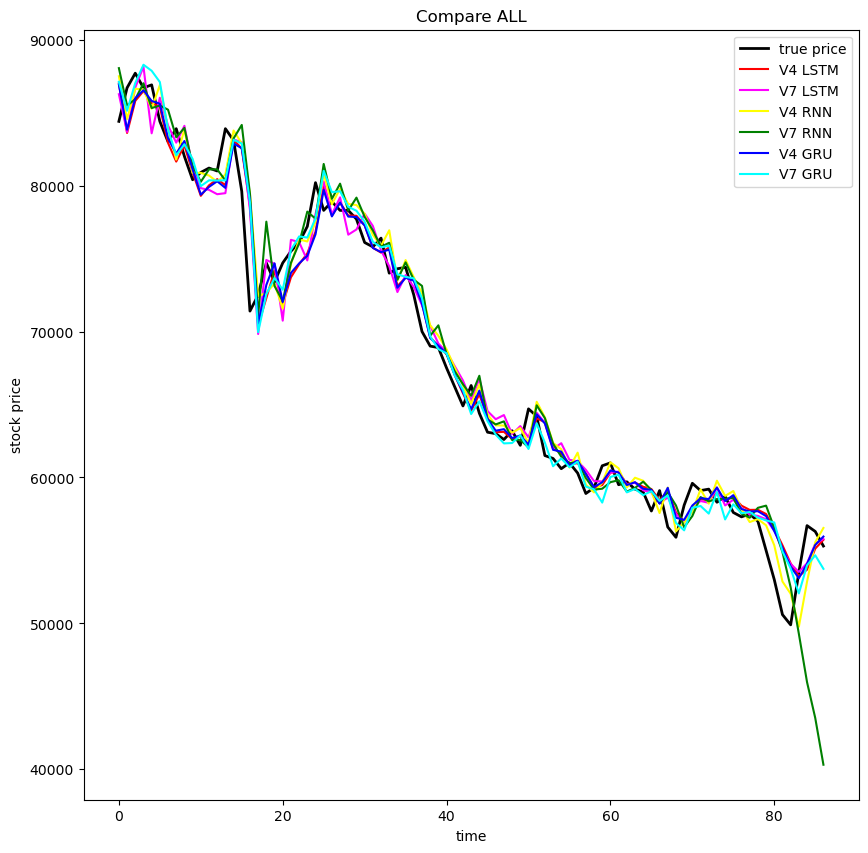

In [56]:
plt.rcParams['figure.figsize'] = [10,10]
plt.plot(y7_test_rescaled_rnn_gru, color='black', linewidth=2, label="true price")
plt.plot(test_predict_rescaled_lstm_v4, color='red', label="V4 LSTM")
plt.plot(test_predict_rescaled_lstm_v7, color='magenta', label="V7 LSTM")
plt.plot(test_predict_rescaled_rnn_v4, color='yellow', label="V4 RNN")
plt.plot(test_predict_rescaled_rnn_v7, color='green', label="V7 RNN")
plt.plot(test_predict_rescaled_rnn_gru_v4, color='blue', label="V4 GRU")
plt.plot(test_predict_rescaled_rnn_gru_v7, color='cyan', label="V7 GRU")

plt.title('Compare ALL')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('ALL.jpg')

plt.show()

변수 개수에 따른 알고리즘별 비교

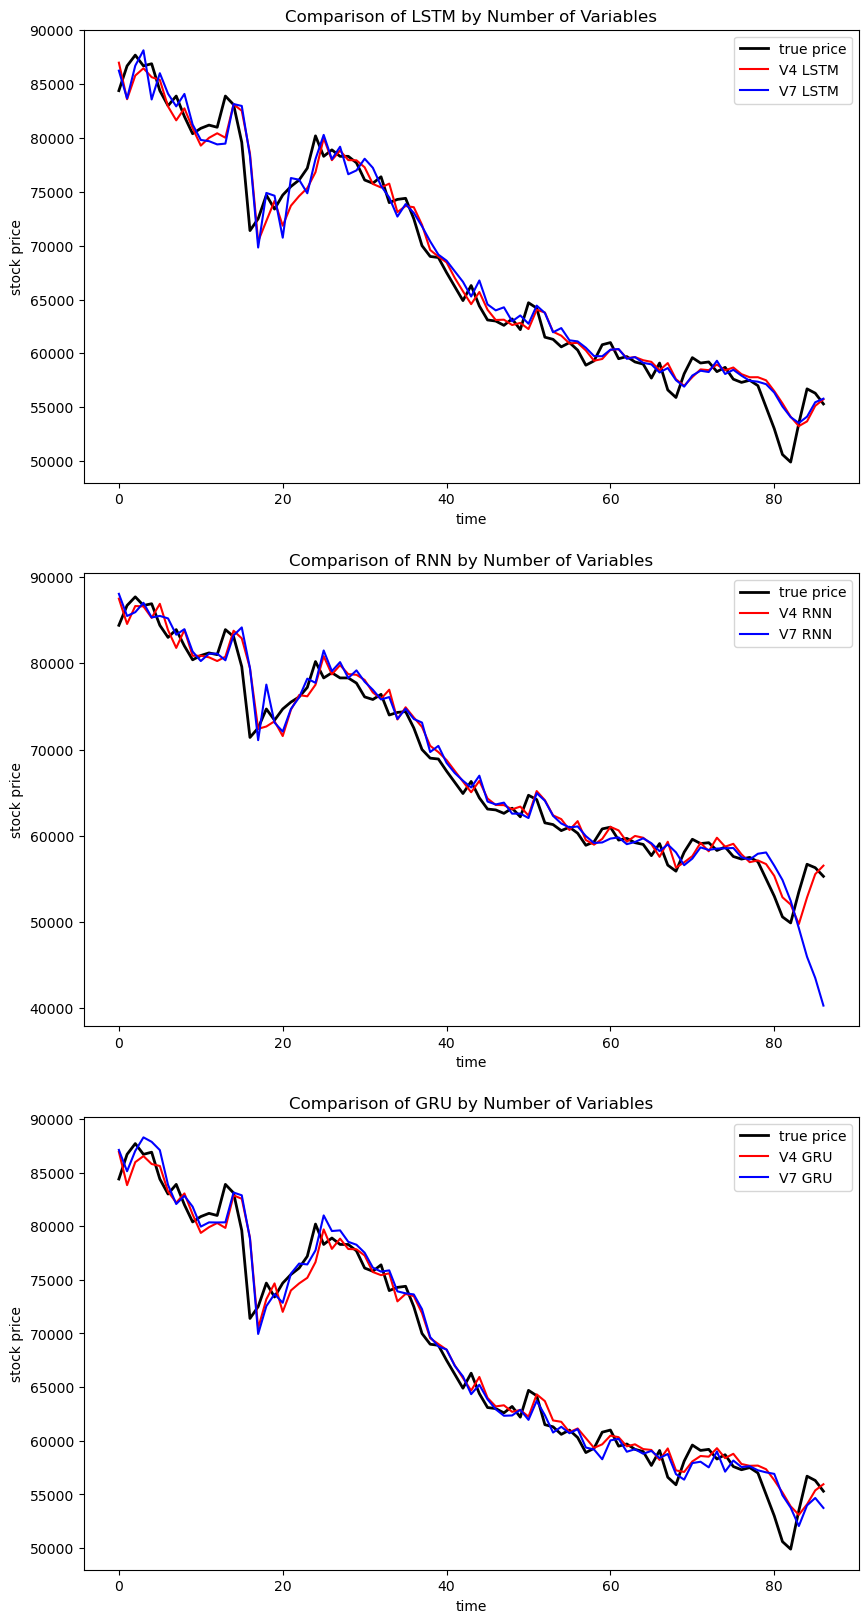

In [57]:
plt.rcParams['figure.figsize'] = [10,20]
plt.subplot(3,1,1)
plt.plot(y7_test_rescaled_rnn_gru, color='black', linewidth=2, label="true price")
plt.plot(test_predict_rescaled_lstm_v4, color='#ff0000', label="V4 LSTM")
plt.plot(test_predict_rescaled_lstm_v7, color='#0000ff', label="V7 LSTM")
plt.title('Comparison of LSTM by Number of Variables')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()

plt.subplot(3,1,2)
plt.plot(y7_test_rescaled_rnn_gru, color='black', linewidth=2, label="true price")
plt.plot(test_predict_rescaled_rnn_v4, color='#ff0000', label="V4 RNN")
plt.plot(test_predict_rescaled_rnn_v7, color='#0000ff', label="V7 RNN")
plt.title('Comparison of RNN by Number of Variables')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()

plt.subplot(3,1,3)
plt.plot(y7_test_rescaled_rnn_gru, color='black', linewidth=2, label="true price")
plt.plot(test_predict_rescaled_rnn_gru_v4, color='#ff0000', label="V4 GRU")
plt.plot(test_predict_rescaled_rnn_gru_v7, color='#0000ff', label="V7 GRU")
plt.title('Comparison of GRU by Number of Variables')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('CAV_Comparison of Algorithms by number of Variables.jpg')

plt.show()

알고리즘에 따른 변수 개수별 비교

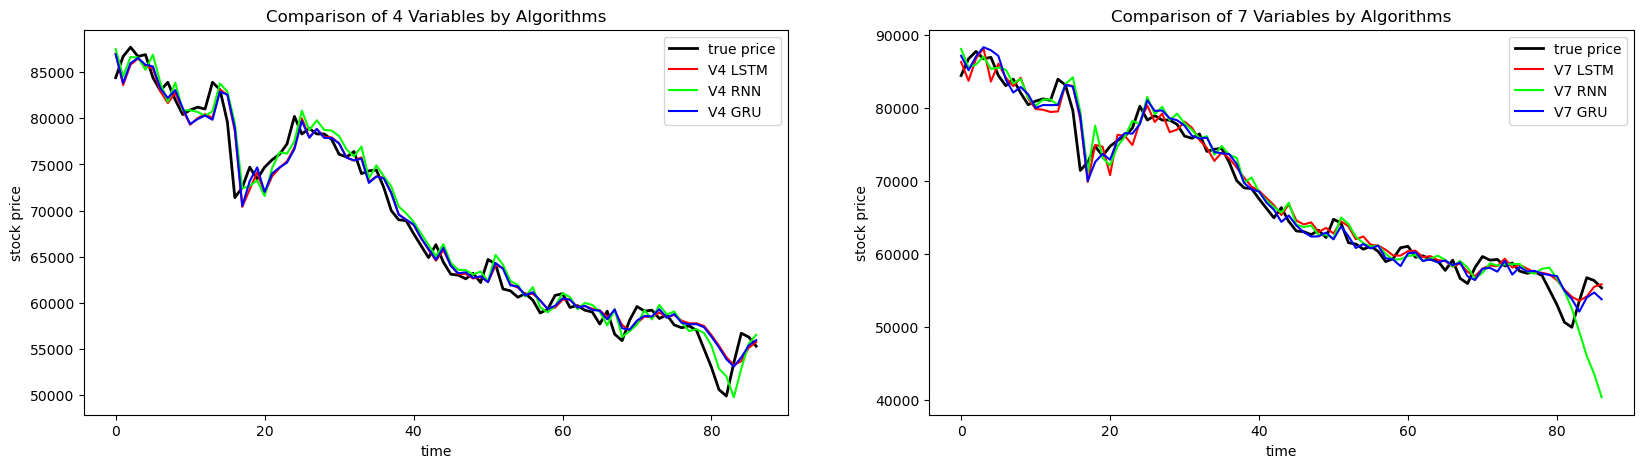

In [58]:
plt.rcParams['figure.figsize'] = [20,5]
plt.subplot(1,2,1)
plt.plot(y7_test_rescaled_rnn_gru, color='black', linewidth=2, label="true price")
plt.plot(test_predict_rescaled_lstm_v4, color='#ff0000', label="V4 LSTM")
plt.plot(test_predict_rescaled_rnn_v4, color='#00ff00', label="V4 RNN")
plt.plot(test_predict_rescaled_rnn_gru_v4, color='#0000ff', label="V4 GRU")
plt.title('Comparison of 4 Variables by Algorithms')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()

plt.subplot(1,2,2)
plt.plot(y7_test_rescaled_rnn_gru, color='black', linewidth=2, label="true price")
plt.plot(test_predict_rescaled_lstm_v7, color='#ff0000', label="V7 LSTM")
plt.plot(test_predict_rescaled_rnn_v7, color='#00ff00', label="V7 RNN")
plt.plot(test_predict_rescaled_rnn_gru_v7, color='#0000ff', label="V7 GRU")
plt.title('Comparison of 7 Variables by Algorithms')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('CVA_Comparison by Number of Variables by Algorithms.jpg')

plt.show()

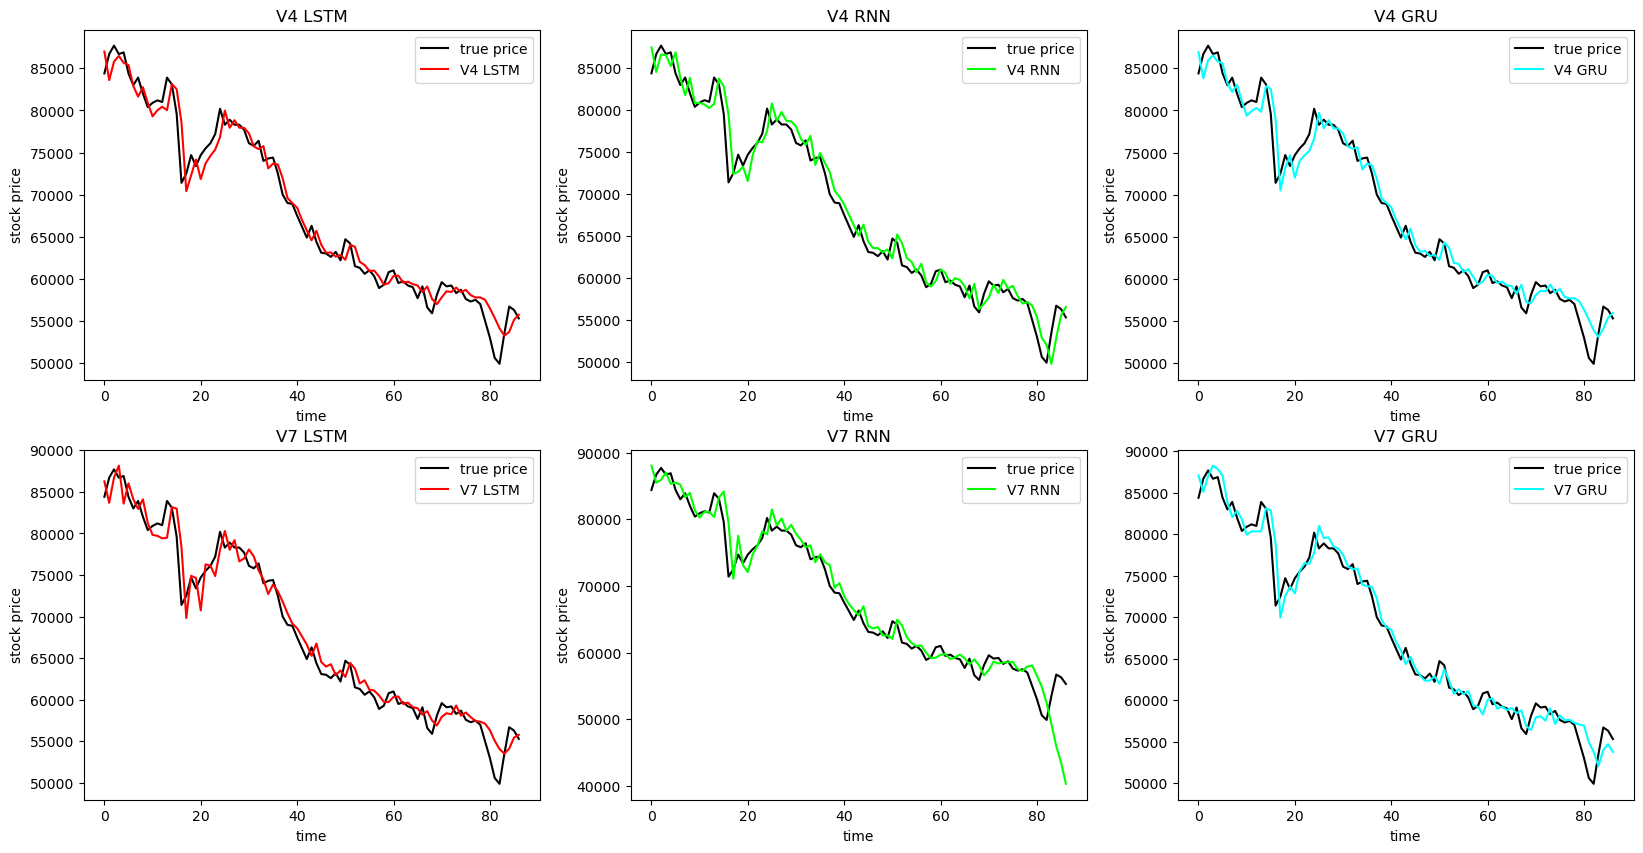

In [59]:
plt.rcParams['figure.figsize'] = [20,10]
plt.subplot(2,3,1)
plt.plot(y7_test_rescaled_rnn_gru, color='black', label="true price")
plt.plot(test_predict_rescaled_lstm_v4, color='red', linewidth=1.5, label="V4 LSTM")
plt.title('V4 LSTM')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()

plt.subplot(2,3,2)
plt.plot(y7_test_rescaled_rnn_gru, color='black', label="true price")
plt.plot(test_predict_rescaled_rnn_v4, color='#00ff00', linewidth=1.5, label="V4 RNN")
plt.title('V4 RNN')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()

plt.subplot(2,3,3)
plt.plot(y7_test_rescaled_rnn_gru, color='black', label="true price")
plt.plot(test_predict_rescaled_rnn_gru_v4, color='cyan', linewidth=1.5, label="V4 GRU")
plt.title('V4 GRU')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()

plt.subplot(2,3,4)
plt.plot(y7_test_rescaled_rnn_gru, color='black', label="true price")
plt.plot(test_predict_rescaled_lstm_v7, color='red', linewidth=1.5, label="V7 LSTM")
plt.title('V7 LSTM')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()

plt.subplot(2,3,5)
plt.plot(y7_test_rescaled_rnn_gru, color='black', label="true price")
plt.plot(test_predict_rescaled_rnn_v7, color='#00ff00', linewidth=1.5, label="V7 RNN")
plt.title('V7 RNN')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()

plt.subplot(2,3,6)
plt.plot(y7_test_rescaled_rnn_gru, color='black', label="true price")
plt.plot(test_predict_rescaled_rnn_gru_v7, color='cyan', linewidth=1.5, label="V7 GRU")
plt.title('V7 GRU')
plt.xlabel("time")
plt.ylabel("stock price")
plt.legend()
plt.savefig('Compare All Case.jpg')

plt.show()